In [1]:
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Evaluation

이번 프로젝트의 워크플로우는 크게 2 종류로 구성되어 있습니다. 

평가를 그에 따라 아래와 같이 진행할 것입니다. 

1. lite 워크플로우 평가
2. router 노드 평가
3. deep 워크플로우 평가 


### Lite 워크플로우 평가
Lite 워크플로우는 최신성을 중점으로 평가하였습니다. 
Ko-freshqa 데이터 셋을 사용해 평가하였으며, 아래 주소에서 확인할 수 있습니다. 

### router 노드 평가

워크플로우가 질문에 따라 질문의 depth를 미리 파악하고, 질의가 단순하고 단일 검색으로 끝날 만한 것이라면,    
router 노드가 lite 워크플로우로 분기합니다. 그에 따라 문제를 정확히 이해하고 어느 정도의 추론이 필요한지 미리 파악하는 것이 중요합니다. 

ko-freshqa 데이터 셋과 deep 노드에서 사용할 만한 쿼리로 데이터 셋을 구성하고, 정확도를 측정하였습니다.    
또한 추론 이유도 함께 뽑아내어 왜 router가 그 노드로 분기시겼는지 확인하였습니다. 

### Deep 워크플로우 평가

딥리서치 워크플로우는 제작된 gold 쿼리 데이터 셋을 사용해 평가하였습니다.   
각 샘플은 **사용자 질문**과 이에 대응하는 **정답 InfluenceReport(JSON)** 으로 구성되어 있으며,   
시스템이 생성한 리포트와 gold 리포트를 비교하는 방식으로 성능을 측정했습니다. 

평가는 다음 두 가지 관점에서 수행했습니다.

* 🟢 **Relaxed Evaluation (완화 평가)**

  * **사실이고, 의미적으로 타당한 대안 답변**까지 인정하는 평가 방식입니다.
  * 시스템 출력이 gold와 정확히 일치하지 않더라도,

    * 동일한 정치인에 대해,
    * 현실에서 실제로 존재하는 정책·사건·기업 관계를 근거 기반으로 설명하고,
    * 질문의 의도(예: “이재명의 정치–경제 영향력 네트워크를 설명하라”)에 **충분히 부합**하는 경우
      **부분 정답 또는 대안 정답**으로 간주합니다.
  * 이때는 LLM-as-Judge 또는 휴먼 리뷰를 활용하여
    0~1 또는 0~5 점수처럼 **연속적인 점수**를 부여하고,
    샘플별 점수를 평균 내어 Relaxed 스코어를 계산합니다.
  * 즉, **“골드와 다르지만 합리적인 다른 해석”**도 성능으로 인정하는 방향의 평가입니다.

* 🔴 **Strict Evaluation (엄격 평가)**

  * gold 리포트에 정의된 **핵심 체인**을 기준으로,

    * 정책/이슈 영역,
    * 산업/섹터,
    * 주요 기업(또는 must_cover 엔티티)가 **충분히 겹치지 않으면 오답**으로 처리하는 방식입니다.   
    
  * 예를 들어, gold가   
    `이재명 → 성남 FC 후원금 → 두산건설·네이버`   
    를 핵심 체인으로 정의했을 때, 시스템이   
    `이재명 → 대북송금 의혹(쌍방울) → 쌍방울그룹·나노스`   
    만을 제시하면, 실제로 존재하는 사건이라 하더라도   
    **gold가 강조한 테마를 포착하지 못한 것**으로 보고 낮은 점수를 부여합니다.   
  * Strict Evaluation에서는 must_cover로 지정한 정책·산업·기업의 **포함 여부**를 중심으로   
    정확도(accuracy) 또는 엔티티 단위 Precision/Recall 등을 집계하여 점수를 산출합니다.   
  * 즉, **“내가 정의한 테마를 얼마나 정확히 따라왔는가”** 를 보는 보수적인 평가입니다.


## Evaluation Agent

### Citation_faithfulness workflow
Hallucination, 실제 기사인지, 추론한 내용이 있는지 평가하는 워크플로우입니다. 

In [2]:
%pwd

'/Users/seyeong/workspace/Upstage_team3/deep_research/evaluation'

In [3]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from eval_graph import CombinedEvalState, combined_eval_app
from typing import Dict, Any, List, Optional


load_dotenv()


async def evaluate_report_evidence(
    model_report: Dict[str, Any],
    gold_report: Optional[Dict[str, Any]] = None,
    question: Optional[str] = None,
) -> Dict[str, Any]:
    """
    Run:
    - Impact Evidence Faithfulness (per-chain, multi-source)
    - Policy Attribution Consistency (per-chain, multi-source)
    - (optionally) Gold vs Model report comparison
    """
    question_for_gold = question or model_report.get("question_answer", "") or ""
    chains = model_report.get("influence_chains", [])

    all_chain_results: List[Dict[str, Any]] = []
    gold_eval: Optional[Dict[str, Any]] = None

    for idx, chain in enumerate(chains):
        # 1) 체인별 state 구성
        chain_state: CombinedEvalState = {
            "politician": chain.get("politician"),
            "policy": chain.get("policy"),
            "industry_or_sector": chain["industry_or_sector"],
            "companies": chain["companies"],
            "impact_description": chain["impact_description"],
            "question": question_for_gold,
            "evidence": chain.get("evidence", []),
        }

        # 2) gold vs model 비교는 질문/리포트 전체 기준이므로
        if gold_report is not None:
            chain_state["gold_report"] = gold_report
            chain_state["model_report"] = model_report

        # 3) 그래프 실행
        print(f"[DEBUG] politiocian: {chain_state['politician']}, policy: {chain_state['policy']}")
        result_state = await combined_eval_app.ainvoke(chain_state)

        # 4) 체인별 결과 수집 (per-chain 단일 결과를 기대)
        impact_result = result_state.get("impact_result")
        attribution_result = result_state.get("attribution_result")

        # BaseModel이면 dict로 변환
        if hasattr(impact_result, "model_dump"):
            impact_result = impact_result.model_dump()
        if hasattr(attribution_result, "model_dump"):
            attribution_result = attribution_result.model_dump()

        all_chain_results.append(
            {
                "chain_index": idx,
                "politician": chain.get("politician"),
                "policy": chain.get("policy"),
                "industry_or_sector": chain["industry_or_sector"],
                "companies": chain["companies"],
                "impact_description": chain["impact_description"],
                "impact_result": impact_result,
                "attribution_result": attribution_result,
            }
        )

        # gold_eval 은 리포트 전체 기준이므로 한 번만 담기
        if gold_report is not None and gold_eval is None:
            gold_eval = result_state.get("gold_eval")
            if hasattr(gold_eval, "model_dump"):
                gold_eval = gold_eval.model_dump()
        
    print("gold_eval : : :", gold_eval)

    return {
        "chain_results": all_chain_results,
        "gold_eval": gold_eval,
    }




모델의 예시 출력

### 단일 결과에 대한 평가

평가는 `evaluate_report_evidence`에 의해 이루어집니다.
모델은 3개의 하위 워크플로우에서 평가합니다.

우선, ChatGPT의 딥리서치 결과인 `gold_report`와 Deep Research 워크플로우가 생성한 결과를 비교합니다.

---

#### 1. Gold Report Alignment (골드 리포트 정합성 평가)

**무엇을 평가하는가?**

* 같은 정치인에 대해:

  * ChatGPT Deep Research가 생성한 `gold_report`
  * 우리 Deep Research 워크플로우가 생성한 `model_report`
    이 두 리포트가 **정책·산업·기업·영향관계 측면에서 얼마나 비슷한 구조와 내용을 가지는지**를 평가합니다.

**어떻게 평가하는가?**

* 하나의 노드에서 다음을 비교하도록 LLM을 호출합니다.

  * 두 리포트의 `question_answer`가 같은 정치인의 **핵심 정책 방향과 산업/기업 영향**을 비슷하게 설명하고 있는지
  * `influence_chains` 수준에서

    * 어떤 정책이 등장하는지
    * 어떤 산업/섹터를 다루는지
    * 어떤 기업들이 언급되는지
    * 각 기업/섹터가 **어떤 방향의 영향(수혜/피해, 성장/위축 등)**을 받는 것으로 설명되는지 

* 이때 Gold는 “정답 레이블”이라기보다는,

  > ChatGPT와 얼마나 비슷한 내용을 다루는지를 평가하기 위함입니다. 

  * 모델 리포트가 Gold와 얼마나 구조적으로/내용적으로 가까운지 확인합니다. 

즉, 이 단계는 “모델 전체 리포트가 우리가 원하는 타입의 분석으로 나왔는지”를 글로벌하게 비교·평가하는 역할을 합니다.

---

#### 2. Impact Evidence Faithfulness

**무엇을 평가하는가?**

* 각 `influence_chain` 단위로,

  * `impact_description` (정책이 특정 산업/기업에 어떤 경제적 영향을 줬다고 모델이 주장하는 문장)
  * 해당 체인에 연결된 `evidence` URL들에서 스크래핑한 기사 본문 (`source`)
    를 비교해서,

> **“이 영향 설명이 실제 기사 내용에 의해 지지되는지 / 아니면 할루시네이션인지”**

를 평가합니다.

**어떻게 평가하는가?**

* `impact_evidence_faithfulness` 워크플로우는 다음 순서로 동작합니다.

  1. `scrape_urls_node`

     * 각 evidence URL을 열어 텍스트를 가져옵니다.
  2. `evaluate_impact_node`

     * 각 URL별로 LLM에게 다음 정보를 넘겨줍니다.

       * `industry_or_sector`
       * `companies`
       * `impact_description`
       * `source`
       * `question`
     * LLM은 **기사 내용 vs 영향 설명**을 비교해 다음 라벨 중 하나를 반환합니다.

       * `SUPPORTED`
       * `PARTIALLY_SUPPORTED`
       * `UNSUPPORTED`
       * `CONTRADICTED`
       * `NOT_ENOUGH_INFO`
     * 함께 `score`(0.0–1.0), `reasoning`(한국어 설명),
       그리고 기사 본문에서 뽑은 `evidence_spans`(관련 문장들)를 제공합니다.

**이 단계가 측정하는 것**

* 할루시네이션 여부:

  * `SUPPORTED / PARTIALLY_SUPPORTED` 비율이 높으면,
    → 모델이 기사의 근거 범위 내에서 합리적인 영향 설명을 생성하고 있다는 뜻
  * `UNSUPPORTED / CONTRADICTED`가 많으면,
    → 모델이 기사에 없는 내용 또는 반대 내용을 만들어내고 있다는 신호
* 또한, **영향 설명의 디테일(수치, 방향성, 수혜/피해 여부 등)이 기사와 얼마나 일치하는지**를 직접적으로 측정합니다.

---

#### 3. Policy Attribution Consistency

**무엇을 평가하는가?**

* 각 `influence_chain` 단위로,

  * 지정된 `politician` + `policy`
  * 해당 체인의 evidence URL로부터 가져온 기사
    사이의 **연관성**을 측정합니다.

> “이 URL은 정말로
> 이 정치인/정책과 관련된 기사인가?”
> “아니면 단지 산업/기업 이름만 같을 뿐, 정책·정치 맥락은 거의 없는 기사인가?”

**어떻게 평가하는가?**

* `policy_attribution_consistency` 워크플로우는 다음을 수행합니다.

  1. URL 스크래핑은 Impact와 동일하게 `scrape_urls_node`에서 처리 (공유)
  2. `evaluate_policy_attribution_node`에서 각 URL별로 LLM을 호출해 다음을 전달:

     * `politician`, `policy`
     * `industry_or_sector`, `companies`
     * `source_title`, `url`, `source`

  3. LLM은 기사와 (politician, policy) 관계를 평가해서:

     * `label`:

       * `HIGHLY_RELATED`
       * `WEAKLY_RELATED`
       * `UNRELATED`
       * `NOT_ENOUGH_INFO`
     * `score`: 0.0–1.0
     * `politician_mentioned`:

       * 기사에서 해당 정치인이 **의미 있게 등장하는지 여부**
     * `policy_topic_mentioned`:

       * 정책 자체 또는 그 핵심 주제(예: 원전 확대, AI 예산, 금산분리 등)가 **실질적으로 다뤄지는지 여부**
     * `evidence_spans`: 관련 구문들
       를 반환합니다.

**이 단계가 측정하는 것**

* **검색/증거 선택 품질**:

  * 모델이 가져온 URL들이 정말 그 정치인과 정책에 관한 기사인지,
  * 아니면 단지 “같은 회사 이름이 잠깐 등장하는 잡다한 기사”인지를 구분합니다.
* 결과적으로, 이 평가는

  * 우리 딥리서치 시스템이 **“정책·정치 맥락에 맞는 근거 기사”**를 잘 고르고 있는지
  * 특정 정치인에게 **관계없는 정책/영향을 억지로 귀속시키고 있지는 않은지**
    를 검증하는 역할을 합니다.

---

#### 4. 세 평가를 합쳐서 보는 관점

정리하면, 단일 결과(한 정치인에 대한 리포트)는 다음 세 축에서 동시에 평가됩니다.

1. **Gold Report Alignment**

   * *“우리가 목표로 삼은 Deep Research 스타일(Gold)과 구조·내용이 비슷한가?”*
   * 정책–산업–기업–영향 체인 구성과 요약 문단 수준에서의 일관성 평가

2. **Impact Evidence Faithfulness (할루시네이션 검증)**

   * *“이 정치인·정책이 기업/산업에 이런 영향을 줬다는 설명이,
     실제 기사 본문과 얼마나 잘 맞는가?”*
   * 기사 근거 기반 vs 모델 생성 내용을 직접 비교

3. **Policy Attribution Consistency (정책 귀속 관련성)**

   * *“이 URL이 정말로 이 정치인과 이 정책에 관한 기사인가?”*
   * 모델의 검색/근거 선택이 정치·정책 맥락에 얼마나 맞는지 평가



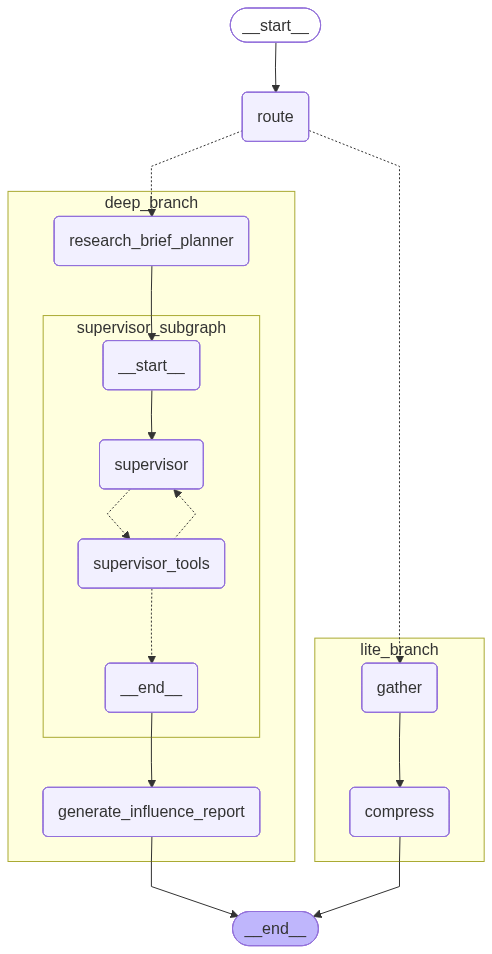

In [4]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research.router import router_builder

checkpointer = InMemorySaver()
full_agent = router_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=-1).draw_mermaid_png()))

In [5]:

import os
import json
import asyncio
from pathlib import Path
from typing import Any, Dict, List
from uuid import uuid4

from dotenv import load_dotenv
from langchain_core.messages import HumanMessage

load_dotenv()
API_KEY = os.getenv("GOOGLE_API_KEY")


def extract_model_response(result: Dict[str, Any]) -> Dict[str, Any]:
    """
    Extract the structured final_report object from the agent result.
    """
    final_report = result.get("final_report")
    if isinstance(final_report, dict):
        return final_report
    # Fallback: just wrap as dict
    return {"final_report_raw": final_report}


async def generate_model_responses_for_influence(
    gold_jsonl_path: str = "../dev_test/influence_gold.jsonl",
    output_jsonl_path: str = "../dev_test/influence_model_responses_3.jsonl",
    base_thread_id: str = "influence",
) -> None:
    """
    For each line in influence_gold.jsonl:
      - read {"question": "...", "gold_report": {...}}
      - call full_agent with that question
      - extract final_report
      - write {"query": question, "gold_report": ..., "model_response": ...} to output JSONL.

    If output_jsonl already has some entries, skip those queries and only run for the remaining ones.
    """
    gold_path = Path(gold_jsonl_path)
    out_path = Path(output_jsonl_path)

    if not gold_path.exists():
        raise FileNotFoundError(f"Gold file not found: {gold_path}")


    processed_queries: set[str] = set()
    if out_path.exists():
        with out_path.open("r", encoding="utf-8") as f_in:
            for line in f_in:
                line = line.strip()
                if not line:
                    continue
                try:
                    rec = json.loads(line)
                except json.JSONDecodeError:
                    continue
                q = rec.get("query")
                if isinstance(q, str):
                    processed_queries.add(q)

    print(f"[INFO] Already processed {len(processed_queries)} queries")

    with gold_path.open("r", encoding="utf-8") as fin, \
         out_path.open("a", encoding="utf-8") as fout:

        for idx, line in enumerate(fin):
            line = line.strip()
            if not line:
                continue

            record = json.loads(line)
            question = record.get("question")
            if not question:
                continue

            # 이미 처리된 query면 스킵
            if question in processed_queries:
                print(f"[SKIP] already processed query: {question}")
                continue

            thread_config = {
                "configurable": {
                    "thread_id": f"{base_thread_id}-{idx}-{uuid4()}",
                    "recursion_limit": 50,
                }
            }

            print(f"[RUN] query={question} (idx={idx})")

            result = await full_agent.ainvoke(
                {"messages": [HumanMessage(content=question)]},
                config=thread_config,
            )

            model_report = extract_model_response(result)

            out_obj = {
                "query": question,
                "gold_report": record.get("gold_report"),
                "model_response": model_report,
            }

            fout.write(json.dumps(out_obj, ensure_ascii=False) + "\n")
            fout.flush()


await generate_model_responses_for_influence()


[INFO] Already processed 18 queries
[SKIP] already processed query: 윤석열
[SKIP] already processed query: 이재명
[SKIP] already processed query: 문재인
[SKIP] already processed query: 박근혜
[SKIP] already processed query: 이명박
[SKIP] already processed query: 홍준표
[SKIP] already processed query: 안철수
[SKIP] already processed query: 이준석
[SKIP] already processed query: 심상정
[SKIP] already processed query: Joe Biden
[SKIP] already processed query: Donald Trump
[SKIP] already processed query: Xi Jinping
[SKIP] already processed query: Vladimir Putin
[SKIP] already processed query: Narendra Modi
[SKIP] already processed query: Rishi Sunak
[SKIP] already processed query: Emmanuel Macron
[RUN] query=Volodymyr Zelensky (idx=16)
[ROUTER] route=deep, reason=The question is an extremely short query consisting solely of a politician's name (Volodymyr Zelensky) with no additional context or specific factual request, making the intent unclear. Per the SPECIAL RULE, this requires the 'deep' route.
[NAVER] original:

In [6]:
import json
import asyncio
from pathlib import Path
from typing import Set

async def evaluate_influence_reports(
    input_jsonl_path: str = "../dev_test/influence_model_responses_3.jsonl",
    output_jsonl_path: str = "../dev_test/influence_model_responses_eval_3.jsonl",
) -> None:
    """
    input_jsonl_path:
      각 줄이
      {
        "query": "...",
        "gold_report": {...},
        "model_response": {...}
      }
      형태인 JSONL 파일.

    output_jsonl_path:
      각 줄이
      {
        "query": "...",
        "evaluation": {...}
      }
      형태인 JSONL 파일.
      이미 존재하면, 기존에 평가된 query는 스킵하고
      새 query만 append 한다.
    """

    in_path = Path(input_jsonl_path)
    out_path = Path(output_jsonl_path)

    if not in_path.exists():
        raise FileNotFoundError(f"Input file not found: {in_path}")

    # 1) 이미 평가된 query 읽어서 set에 저장
    processed_queries: Set[str] = set()
    if out_path.exists():
        with out_path.open("r", encoding="utf-8") as f_out_read:
            for line in f_out_read:
                line = line.strip()
                if not line:
                    continue
                try:
                    rec = json.loads(line)
                except json.JSONDecodeError:
                    continue
                q = rec.get("query")
                if isinstance(q, str):
                    processed_queries.add(q)

    print(f"[INFO] already processed {len(processed_queries)} queries")

    # 2) output은 append 모드로 열기 (새로운 평가 결과 추가)
    with in_path.open("r", encoding="utf-8") as fin, \
         out_path.open("a", encoding="utf-8") as fout:

        for idx, line in enumerate(fin):
            line = line.strip()
            if not line:
                continue

            record = json.loads(line)

            query = record.get("query")
            gold_report = record.get("gold_report")
            model_report = record.get("model_response")

            print(f"[DEBUG] Processing line {idx}, query={query}")
            print(f"[DEBUG] Gold report keys: {gold_report}")
            print(f"[DEBUG] Model report keys: {model_report}")
            

            if not query or not gold_report or not model_report:
                print(f"[WARN] line {idx}: missing fields, skipping")
                continue

            # 이미 평가한 query면 스킵
            if query in processed_queries:
                print(f"[SKIP] already evaluated query: {query}")
                continue
            
            # 평가 함수 호출
            result = await evaluate_report_evidence(
                model_report=model_report,
                gold_report=gold_report,
                question=query,
            )

            out_record = {
                "query": query,
                "evaluation": result,
            }

            fout.write(json.dumps(out_record, ensure_ascii=False) + "\n")
            fout.flush()

            if (idx + 1) % 10 == 0:
                print(f"[INFO] processed {idx + 1} lines")

    print(f"[DONE] saved eval JSONL to {out_path}")


In [7]:
await evaluate_influence_reports()

[INFO] already processed 18 queries
[DEBUG] Processing line 0, query=윤석열
[DEBUG] Gold report keys: {'report_title': '윤석열 전 대통령의 정치·경제 영향력 네트워크 분석', 'time_range': '2025년 11월 24일 기준', 'question_answer': '윤석열 전 대통령은 원전 확대 정책으로 두산에너빌리티와 한국전력 등 원전 관련 기업에 수혜를 주었으며, 동시에 원전 중심 기조는 한화솔루션의 태양광 사업에 부정적 영향을 미쳤습니다. 또한 국방비 증액과 기술 육성 정책으로 방산 및 첨단산업 기업의 성장에 기여했으며, 미국·일본과의 동맹 강화 및 중동 경제협력 확대를 통해 국제적 영향력을 도모했습니다.', 'influence_chains': [{'politician': '윤석열', 'policy': '원전 확대 정책', 'industry_or_sector': '에너지/원전', 'companies': ['두산에너빌리티'], 'impact_description': '윤석열 정부가 신한울 3·4호기 건설 등 원전 사업을 재개하면서 두산에너빌리티가 원전 주기기 제작 수주와 SMR 기술 개발 지원을 받는 등 직접적 수혜를 입었습니다:contentReference[oaicite:0]{index=0}. 글로벌 에너지 위기 속 원전 수요 증가로 해당 기업의 재무 실적도 개선되었습니다.', 'evidence': [{'source_title': '윤석열 정책 수혜주 2편] 전 두산중공업(현 두산에너빌리티), 친원전 ...', 'url': 'https://contents.premium.naver.com/richplatform/therichplatform/contents/220416185027884GB'}]}, {'politician': '윤석열', 'policy': '원전 중심 에너지정책', 'industry_or_sector': '신재생에너지/태양광', 'companies':

I0000 00:00:1764996303.363160 2644040 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764996303.381748 2644040 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[DEBUG] politiocian: Volodymyr Zelensky, policy: EU 통합 노력


I0000 00:00:1764996326.387826 2644040 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[DEBUG] politiocian: Volodymyr Zelensky, policy: 반부패 개혁


I0000 00:00:1764996348.469913 2644040 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764996348.479672 2644040 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


gold_eval : : : {'similarity_score': 0.4, 'reasoning': "두 보고서는 볼로디미르 젤렌스키의 정치·경제적 영향력을 분석하며 '반부패 개혁' 정책과 'DTEK' 기업을 공통적으로 언급합니다. 그러나 gold_report는 서방 군사지원으로 인한 방위산업 특수와 우크라이나 재건 사업에 초점을 맞춰 정책과 기업 간의 연관성 및 경제적 파급 효과를 구체적으로 설명하는 반면, model_report는 젤렌스키의 미디어/엔터테인먼트 산업 배경과 EU 통합 노력을 주요 내용으로 다루며 일부 정책의 경제적 영향 설명이 부족합니다.", 'model_unique_points': ['젤렌스키의 과거 미디어/엔터테인먼트 산업(Kvartal 95, 1+1 Media) 활동 및 올리가르히와의 연관성.', 'EU 통합 노력이 우크라이나 에너지 산업에 미치는 영향.'], 'gold_unique_points': ['서방 군사지원 외교를 통한 글로벌 방위산업(Lockheed Martin, BAE Systems)의 경제적 영향.', 'PrivatBank 국유화 및 올리가르히(Metinvest) 견제를 포함한 금융/철강 부문의 반부패·재벌 개혁.', '전력·농업 인프라 복구 및 우크라이나 재건 계획(Bechtel)을 통한 건설/전력 산업의 활성화.']}
[DEBUG] Processing line 17, query=Fumio Kishida
[DEBUG] Gold report keys: {'report_title': '기시다 후미오 일본 총리의 정치·경제 영향력 네트워크 분석', 'time_range': '2021–2025년 11월 24일 기준', 'question_answer': "기시다 총리는 방위비를 대폭 증액하여 미쓰비시중공업 등 방산기업에 새로운 성장 기회를 제공했고, 핵심전략산업(반도체·배터리)에 보조금을 지급하여 일본 기업의 국내 투자와 TSMC 등의 유치를 이끌었습니다. 또한 '새로운 자본주의' 기치 하에 기업들에 임금 인상과 투자 확대를 독려

In [ ]:
import json
from pathlib import Path
from typing import Dict, Any, List, Optional
from collections import Counter


def _is_valid_evidence_item(item: Dict[str, Any]) -> bool:
    """
    Return True if this evidence item should be used for scoring.
    Filters out:
      - NOT_ENOUGH_INFO labels
    """
    label = item.get("label")
    if label == "NOT_ENOUGH_INFO":
        return False
    return True


def extract_scores_from_record(record: Dict[str, Any]) -> Dict[str, Any]:
    """
    Given a single JSON record like:
      { "query": "...", "evaluation": { ... } }

    Return:
      {
        "impact_scores": [...],
        "impact_labels": [...],
        "attribution_scores": [...],
        "attribution_labels": [...],
        "gold_score": float | None
      }

    """
    evaluation = record.get("evaluation", {}) or {}
    chain_results: List[Dict[str, Any]] = evaluation.get("chain_results", []) or []

    impact_scores: List[float] = []
    impact_labels: List[str] = []
    attribution_scores: List[float] = []
    attribution_labels: List[str] = []

    for chain in chain_results:
        # -------- Impact Evidence --------
        impact_item = chain.get("impact_result") or {}
        if isinstance(impact_item, dict) and _is_valid_evidence_item(impact_item):
            score = impact_item.get("score")
            label = impact_item.get("label")

            if isinstance(score, (int, float)):
                impact_scores.append(float(score))
            if isinstance(label, str):
                impact_labels.append(label)

        # -------- Policy Attribution --------
        attr_item = chain.get("attribution_result") or {}
        if isinstance(attr_item, dict) and _is_valid_evidence_item(attr_item):
            score = attr_item.get("score")
            label = attr_item.get("label")

            if isinstance(score, (int, float)):
                attribution_scores.append(float(score))
            if isinstance(label, str):
                attribution_labels.append(label)

    gold_eval = evaluation.get("gold_eval", {}) or {}
    gold_score = gold_eval.get("similarity_score")
    if not isinstance(gold_score, (int, float)):
        gold_score = None

    return {
        "impact_scores": impact_scores,
        "impact_labels": impact_labels,
        "attribution_scores": attribution_scores,
        "attribution_labels": attribution_labels,
        "gold_score": gold_score,
    }


def _mean(xs: List[float]) -> Optional[float]:
    return sum(xs) / len(xs) if xs else None


def compute_averages_from_jsonl(path: str) -> Dict[str, Any]:
    """
    Read a JSONL file where each line is:
      { "query": "...", "evaluation": {...} }

    Aggregate all valid scores across records and compute global averages,
    plus label counts for impact / attribution.
    """
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(p)

    all_impact: List[float] = []
    all_attr: List[float] = []
    all_gold: List[float] = []

    all_impact_labels: List[str] = []
    all_attr_labels: List[str] = []

    with p.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            record: Dict[str, Any] = json.loads(line)

            per = extract_scores_from_record(record)
            all_impact.extend(per["impact_scores"])
            all_attr.extend(per["attribution_scores"])
            all_impact_labels.extend(per["impact_labels"])
            all_attr_labels.extend(per["attribution_labels"])
            if per["gold_score"] is not None:
                all_gold.append(per["gold_score"])

    impact_label_counts = dict(Counter(all_impact_labels))
    attribution_label_counts = dict(Counter(all_attr_labels))

    return {
        "impact_avg": _mean(all_impact),
        "impact_label_counts": impact_label_counts,
        "attribution_avg": _mean(all_attr),
        "attribution_label_counts": attribution_label_counts,
        "gold_avg": _mean(all_gold),
    }


In [15]:
compute_averages_from_jsonl("../dev_test/influence_model_responses_eval_3.jsonl")

{'impact_avg': 0.7345454545454544,
 'impact_label_counts': {'SUPPORTED': 33,
  'PARTIALLY_SUPPORTED': 14,
  'CONTRADICTED': 2,
  'UNSUPPORTED': 6},
 'attribution_avg': 0.8338596491228066,
 'attribution_label_counts': {'HIGHLY_RELATED': 44,
  'WEAKLY_RELATED': 12,
  'UNRELATED': 1},
 'gold_avg': 0.42105263157894735}